In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SpectralAnomalyScore2)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1943: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [2]:
# setting to make life easier
Temperature='floatvalue'
kmeans='TemperatureKmeansScore'
fft='TemperatureFFTScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

#kmeans_break=1.3
#spectral_break = 2.8
#fft_break = 100
#sal_break = 100
#gen_break = 30000
kmeans_break=100
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 30000



#### What will be shown

General approach is straightforward
* read raw data in
* transform it so that it is compatible to the Monitoring pipeline
* add yet another anomaly detector based on computer vision technology. The point here is to show how to run pipeline anomaly functions 'locally', an important concept for automated testing.
* simplify the dataframe - we have only one entity, no need for an entity index
* render input data and anomaly scores properly scaled

<br>

We start with Microsoft's anomaly test data found here
https://github.com/microsoft/anomalydetector/blob/master/samples/sample.csv

and then proceed to applying anomaly detection to real life pump data


<br>


#### Current inventory of anomaly detectors by type

This is the list of functions to apply


| Detector | ML Type | Type         | How does it work |
| ------- | ------------ | ------- | ---------------- |
| KMeans | Unsupervised | Proximity | Clusters data points in centroid buckets, small buckets are outliers, score is distance to closest other bucket |
| Generalized | Unsupervised | Linear Model | Covariance matrix over data point vectors serves to measure multi-dimensional deviation |
| FFT | Unsupervised | Linear Model | Run FFT before applying Generalized |
| Spectral | Unsupervised | Linear Model | Compute signal energy to reduce dimensions |
| Saliency | Unsupervised | Linear Model | Apply saliency transform (from computer vision |
| SimpleAnomaly | **Supervised** | Ensemble | Run Gradient boosting on training data, anomaly if prediction deviates from actual data |
| --- | **Supervised** | LSTM | Train a stacked LSTM, anomaly if prediction deviates from actual data |



In [3]:

# Get stuff in
df_i = pd.read_csv('./Float IO Point Anaomaly ScoreIssue818.csv',
                   index_col=False, parse_dates=['timestamp'], dtype={"floatvalue": "float64"})

#df_i['entity']='MyRoom'
df_i['floatvalue']=df_i['floatvalue'] -20
#df_i = df_i.drop(columns=['value'])
df_i['entity']=df_i['deviceid']

# drop columns we don't need
df_i.drop(columns=['floatvalue_saliencyscore','floatvalue_kmeansscore',
                   'floatvalue_spectralScore','floatvalue_GenScore','floatvalue_FFTScore'],inplace=True)

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['timestamp']).dropna()


#df_i = df_i.between_time('11:00', '17:00')
df_i = df_i.between_time('13:00', '15:00')
df_i = df_i.reset_index().set_index(['entity','timestamp'])
df_i.head(2)


deviceid  floatvalue
entity           timestamp                                        
CakebreadId_0128 2020-01-31 13:00:00  CakebreadId_0128        23.0
                 2020-01-31 13:01:00  CakebreadId_0128        22.0

In [4]:
# Now run the anomaly functions as if they were executed in a pipeline

spsi = SpectralAnomalyScore2(Temperature, 12, spectral, 'signal_energy', 'inv_zscore')
et = spsi._build_entity_type(columns = [Column(Temperature,Float())])
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

sali = SaliencybasedGeneralizedAnomalyScore(Temperature, 12, sal)
et = sali._build_entity_type(columns = [Column(Temperature,Float())])
sali._entity_type = et
df_i = sali.execute(df=df_i)

ffti = FFTbasedGeneralizedAnomalyScore(Temperature, 12, fft)
et = ffti._build_entity_type(columns = [Column(Temperature,Float())])
ffti._entity_type = et
df_i = ffti.execute(df=df_i)

kmi = KMeansAnomalyScore(Temperature, 2, kmeans)
et = kmi._build_entity_type(columns = [Column(Temperature,Float())])
kmi._entity_type = et
df_i = kmi.execute(df=df_i)

df_i.head(4)

2020-03-03T17:20:46.744 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-03-03T17:20:46.745 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
                               entity          deviceid  floatvalue  \
timestamp                                                             
2020-01-31 13:00:00  CakebreadId_0128  CakebreadId_0128        23.0   
2020-01-31 13:01:00  CakebreadId_0128  CakebreadId_0128        22.0   
2020-01-31 13:01:00  CakebreadId_0128  CakebreadId_0128        23.0   

                     TemperatureSpectralScore_x  TemperatureSpectralScore_y  \
timestamp                                                                     
2020-01-31 13:00:00                           0                   33.888950   
2020-01-31 13:01:00                           0                   36.233168   
2020-01-31 1

deviceid  floatvalue  \
entity           timestamp                                           
CakebreadId_0128 2020-01-31 13:00:00  CakebreadId_0128        23.0   
                 2020-01-31 13:01:00  CakebreadId_0128        22.0   
                 2020-01-31 13:01:00  CakebreadId_0128        23.0   
                 2020-01-31 13:01:00  CakebreadId_0128        22.0   

                                      TemperatureSpectralScore  signal_energy  \
entity           timestamp                                                      
CakebreadId_0128 2020-01-31 13:00:00                 33.888950       0.195641   
                 2020-01-31 13:01:00                 36.233168       0.129808   
                 2020-01-31 13:01:00                 36.233168       0.129808   
                 2020-01-31 13:01:00                 36.233168       0.129808   

                                      inv_zscore  SaliencyAnomalyScore  \
entity           timestamp                                               
CakebreadId_0128 2020-01-31 13:00:00    1.745079              1.167744   
                 2020-01-31 13:01:00    1.079766              4.060016   
                 2020-01-31 13:01:00    1.079766              4.060016   
                 2020-01-31 13:01:00    1.079766              4.060016   

                                      TemperatureFFTScore  \
entity           timestamp                                  
CakebreadId_0128 2020-01-31 13:00:00             3.111435   
                 2020-01-31 13:01:00             3.136649   
                 2020-01-31 13:01:00             3.136649   
                 2020-01-31 13:01:00             3.136649   

                                      TemperatureKmeansScore  
entity           timestamp                                    
CakebreadId_0128 2020-01-31 13:00:00               -5.111821  
                 2020-01-31 13:01:00                5.079053  
                 2020-01-31 13:01:00                5.079053  
                 2020-01-31 13:01:00                5.079053

In [5]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['CakebreadId_0128']]
df_inputm2.reset_index(level=[0], inplace=True)
#df_inputm2.head(4)
df_inputm2.describe()

,floatvalue,TemperatureSpectralScore,signal_energy,inv_zscore,SaliencyAnomalyScore,TemperatureFFTScore,TemperatureKmeansScore
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,22.585987,29.852933,1.146275,0.890376,71.893199,21.413347,18.022759
std,1.789371,18.819542,0.992181,0.481788,89.948937,18.009487,33.120705
min,17.000000,0.029144,0.095768,0.001679,1.167744,-14.585827,-5.111821
25%,22.000000,16.568024,0.170354,0.669490,7.111584,4.712903,0.695323
50%,23.000000,31.974526,1.065709,0.782414,20.699129,19.923172,1.744301
75%,24.000000,36.611293,1.794019,1.003860,112.610640,38.586734,17.933699
max,26.000000,84.796598,3.528705,2.532696,320.890043,66.717308,181.836526


In [6]:
f, t, Sxx = sp.signal.spectrogram(df_inputm2[Temperature], 1, window='hanning', 
                                  nperseg=12, noverlap=1, detrend='l', scaling='spectrum')

f_, Pxx_den = sp.signal.periodogram(df_inputm2[Temperature], 1)

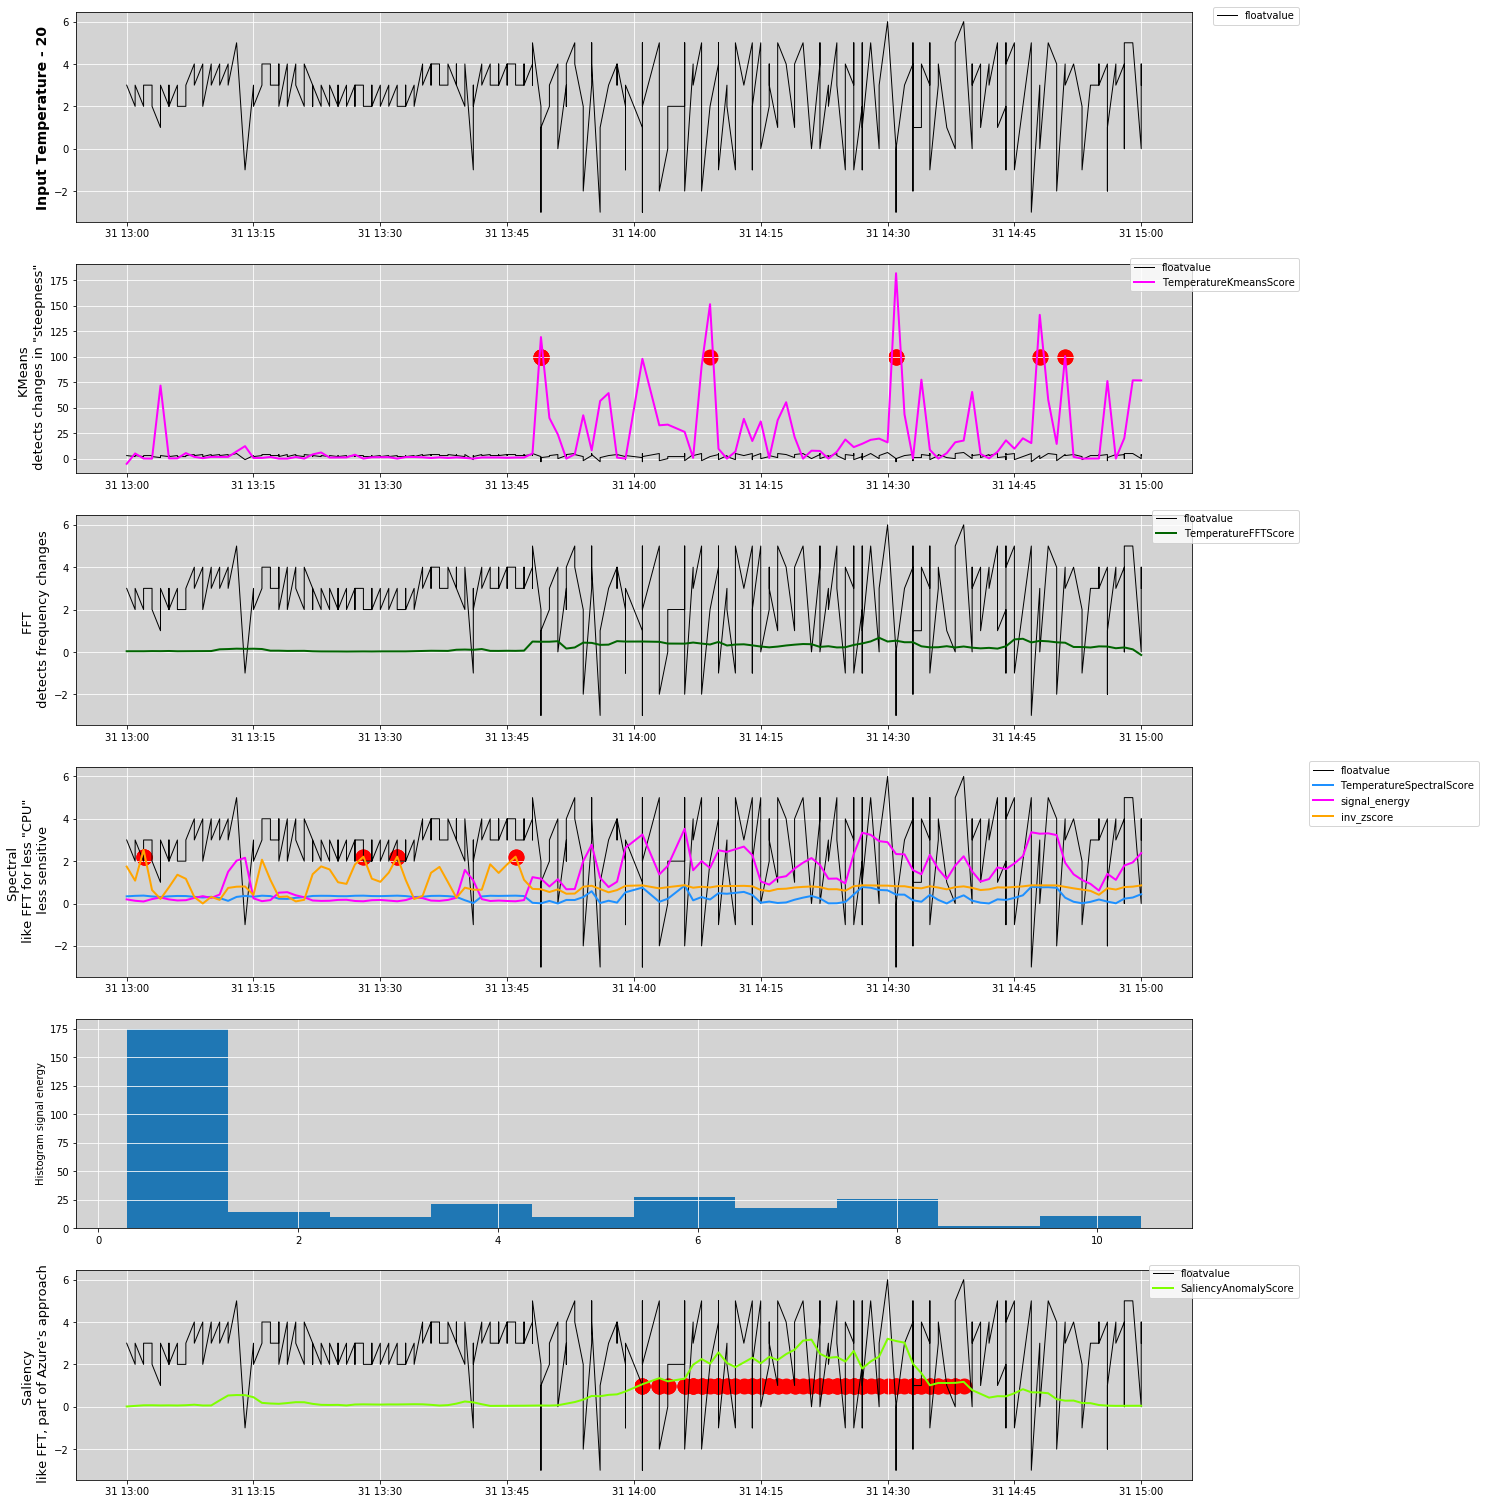

In [8]:
# df_inputm2[spectral].values[df_inputm2[spectral] > 0.001] = 0.001
# df_inputm2[fft].values[df_inputm2[fft] < -1] = -1
df_inputm2[kmeansA] = df_inputm2[kmeans]
df_inputm2[kmeansA].values[df_inputm2[kmeansA] < kmeans_break] = np.nan
df_inputm2[kmeansA].values[df_inputm2[kmeansA] > kmeans_break] = kmeans_break

# Scale spectral and saliency 
# df_inputm2[spectral].values[df_inputm2[spectral] >= spectral_break] = -spectral_break
# df_inputm2[sal].values[df_inputm2[sal] > sal_break] = sal_break
df_inputm2['inv_zscoreA'] = df_inputm2['inv_zscore']
df_inputm2['inv_zscoreA'].values[df_inputm2['inv_zscoreA'] < 2.2] = np.nan
df_inputm2['inv_zscoreA'].values[df_inputm2['inv_zscoreA'] > 2.2] = 2.2



df_inputm2[fftA] = df_inputm2[fft]
df_inputm2[fftA].values[df_inputm2[fftA] < fft_break] = np.nan
df_inputm2[fftA].values[df_inputm2[fftA] > fft_break] = fft_break
df_inputm2[spectralA] = df_inputm2[spectral]
df_inputm2[spectralA].values[df_inputm2[spectralA] < spectral_break] = np.nan
df_inputm2[spectralA].values[df_inputm2[spectralA] > spectral_break] = spectral_break
df_inputm2[salA] = df_inputm2[sal]
df_inputm2[salA].values[df_inputm2[salA] < sal_break] = np.nan
df_inputm2[salA].values[df_inputm2[salA] > sal_break] = sal_break
#df_inputm2[genA] = df_inputm2[gen]
#df_inputm2[genA].values[df_inputm2[genA] < gen_break] = np.nan
#df_inputm2[genA].values[df_inputm2[genA] > gen_break] = gen_break

plots = 6

fig, ax = plt.subplots(plots, 1, figsize=(20,plots * 4.5))
cnt = 0
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input Temperature - 20',fontsize=14,weight="bold")
cnt = cnt+1

ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
#ax[cnt].plot(df_inputm2.index, df_inputm2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].scatter(df_inputm2.index,df_inputm2[kmeansA], linewidth=10, color='red')
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects changes in "steepness"',fontsize=13)
cnt = cnt+1
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].scatter(df_inputm2.index, df_inputm2[fftA]/fft_break, linewidth=10, color='red')
#ax[cnt].plot(df_inputm2.index, df_inputm2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)

cnt = cnt+1
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputm2.index, df_inputm2['signal_energy'], linewidth=2,color='magenta', label='signal_energy')
ax[cnt].plot(df_inputm2.index, df_inputm2['inv_zscore'], linewidth=2,color='orange', label='inv_zscore')
ax[cnt].scatter(df_inputm2.index,df_inputm2['inv_zscoreA'], linewidth=10, color='red')

ax[cnt].scatter(df_inputm2.index, df_inputm2[spectralA]/spectral_break, linewidth=10, color='red')
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n like FFT for less "CPU"\n less sensitive', fontsize=13)

#cnt=cnt+1
#ax[cnt].pcolormesh(t, f, Sxx)
#ax[cnt].set_ylabel('Frequency')
#ax[cnt].set_xlabel('Time')

cnt=cnt+1

ax[cnt].hist(1/df_inputm2['signal_energy'])

#ax[cnt].semilogy(f_, Pxx_den)
ax[cnt].set_ylabel('Histogram signal energy')
#ax[cnt].set_xlabel('Time')
#ax[cnt].set_ylim([1e-1, 1e2])


cnt=cnt+1
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].scatter(df_inputm2.index, df_inputm2[salA]/sal_break, linewidth=10, color='red')
#ax[cnt].plot(df_inputm2.index, df_inputm2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n like FFT, part of Azure\'s approach', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

#### Results

Clear **winners** are 
* **KMeans** with a very small window size of 2 and 
* **Saliency**.

